# Stock price prediction  using LSTM deep learning
### LSTM uses the closing price of the stock in the last 2 trading weeks (10 Days) to predict the current day's price. LSTM was chosen because of its reputation for making predictions with time series data.

## Import libraries and load dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import chart_studio.ploltly as py
import plotly.graph_objs as go
from plotly.offline import plot

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## NVDA1 Contains data from 2019, ltsm bad at extrapolating data, train with data that likely represents the range which NVDA is likely to trade in for the prediction week

In [2]:
df = pd.read_csv('NVDA1.csv',parse_dates=True)
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(df['Date'], inplace=True)
df

,Date,Close
Date,,
2019-01-02,2019-01-02,34.055000
2019-01-03,2019-01-03,31.997499
2019-01-04,2019-01-04,34.047501
2019-01-07,2019-01-07,35.849998
2019-01-08,2019-01-08,34.957500
...,...,...
2022-10-17,2022-10-17,118.879997
2022-10-18,2022-10-18,119.669998
2022-10-19,2022-10-19,120.510002


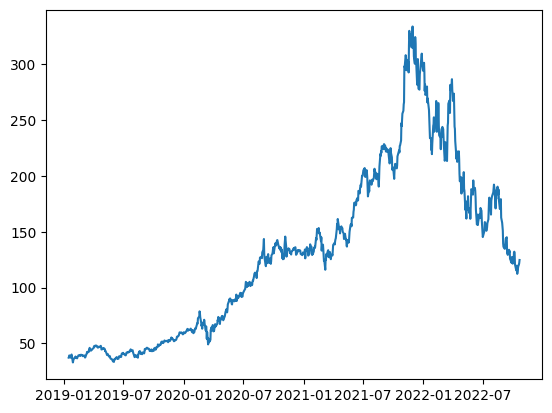

In [5]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['Close'])
plt.show()

## Pre process data to generate 10 day window

In [6]:
# 10 day window
last_col = 'Close'
window_size = 10
for i in range(1, window_size + 1):
    column_name = f"Close-{i}"
    df[column_name] = df[last_col].shift(+1).ffill()
    last_col = column_name

df = df.iloc[window_size:]
df

/var/folders/z3/k29jsmxx1ds3zc21hy27hhk40000gn/T/ipykernel_9769/3712227068.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Close,Close-1,Close-2,Close-3,Close-4,Close-5,Close-6,Close-7,Close-8,Close-9,Close-10
Date,,,,,,,,,,,,
2019-01-31,2019-01-31,35.937500,34.347500,32.900002,34.502499,40.037498,39.459999,37.322498,37.192501,39.232498,37.930000,37.209999
2019-02-01,2019-02-01,36.182499,35.937500,34.347500,32.900002,34.502499,40.037498,39.459999,37.322498,37.192501,39.232498,37.930000
2019-02-04,2019-02-04,37.294998,36.182499,35.937500,34.347500,32.900002,34.502499,40.037498,39.459999,37.322498,37.192501,39.232498
2019-02-05,2019-02-05,37.487499,37.294998,36.182499,35.937500,34.347500,32.900002,34.502499,40.037498,39.459999,37.322498,37.192501
2019-02-06,2019-02-06,38.250000,37.487499,37.294998,36.182499,35.937500,34.347500,32.900002,34.502499,40.037498,39.459999,37.322498
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-17,2022-10-17,118.879997,112.269997,119.599998,115.000000,115.860001,116.699997,120.760002,131.300003,132.089996,131.669998,125.120003
2022-10-18,2022-10-18,119.669998,118.879997,112.269997,119.599998,115.000000,115.860001,116.699997,120.760002,131.300003,132.089996,131.669998
2022-10-19,2022-10-19,120.510002,119.669998,118.879997,112.269997,119.599998,115.000000,115.860001,116.699997,120.760002,131.300003,132.089996


In [7]:
df_as_np = df.to_numpy()
dates = df_as_np[:, 0]
mid = df_as_np[:, 1:-1]

X = mid.reshape((len(dates), mid.shape[1], 1))
X = X.astype(np.float32)
y = df_as_np[:, -1]
y = y.astype(np.float32)
dates.shape, X.shape, y.shape

((940,), (940, 10, 1), (940,))

In [8]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

2022-10-23 11:18:25.472715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
model = Sequential([layers.Input((window_size, 1)),
                  layers.LSTM(64),
                  layers.Dense(32, activation='relu'),
                  layers.Dense(32, activation='relu'),
                  layers.Dense(1)])

model.compile(loss='mse', 
             optimizer=Adam(learning_rate=0.001),
             metrics=['mean_absolute_error'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300)

2022-10-23 11:19:08.813605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/300
24/24 [==============================] - 2s 22ms/step - loss: 18583.9316 - mean_absolute_error: 114.3394 - val_loss: 53108.1797 - val_mean_absolute_error: 228.0149
Epoch 2/300
24/24 [==============================] - 0s 5ms/step - loss: 18152.2559 - mean_absolute_error: 112.1387 - val_loss: 51718.2461 - val_mean_absolute_error: 224.9332
Epoch 3/300
24/24 [==============================] - 0s 5ms/step - loss: 16332.2842 - mean_absolute_error: 102.4145 - val_loss: 44646.1953 - val_mean_absolute_error: 208.5461
Epoch 4/300
24/24 [==============================] - 0s 5ms/step - loss: 11321.5508 - mean_absolute_error: 76.5893 - val_loss: 28629.1758 - val_mean_absolute_error: 165.6538
Epoch 5/300
24/24 [==============================] - 0s 5ms/step - loss: 6331.2002 - mean_absolute_error: 61.1766 - val_loss: 14346.0576 - val_mean_absolute_error: 115.0201
Epoch 6/300
24/24 [==============================] - 0s 5ms/step - loss: 4988.0952 - mean_absolute_error: 56.9455 - val_loss: 1

Epoch 50/300
24/24 [==============================] - 0s 4ms/step - loss: 22.3661 - mean_absolute_error: 3.1490 - val_loss: 137.3219 - val_mean_absolute_error: 9.4331
Epoch 51/300
24/24 [==============================] - 0s 5ms/step - loss: 18.5609 - mean_absolute_error: 2.7699 - val_loss: 109.6929 - val_mean_absolute_error: 8.5676
Epoch 52/300
24/24 [==============================] - 0s 5ms/step - loss: 20.2373 - mean_absolute_error: 2.8631 - val_loss: 127.5256 - val_mean_absolute_error: 9.3065
Epoch 53/300
24/24 [==============================] - 0s 5ms/step - loss: 19.0850 - mean_absolute_error: 2.8811 - val_loss: 110.8646 - val_mean_absolute_error: 8.6014
Epoch 54/300
24/24 [==============================] - 0s 5ms/step - loss: 22.7007 - mean_absolute_error: 3.2036 - val_loss: 147.3792 - val_mean_absolute_error: 9.8883
Epoch 55/300
24/24 [==============================] - 0s 5ms/step - loss: 23.2102 - mean_absolute_error: 3.3892 - val_loss: 126.2528 - val_mean_absolute_error: 9.392

24/24 [==============================] - 0s 7ms/step - loss: 19.3304 - mean_absolute_error: 2.7750 - val_loss: 107.8517 - val_mean_absolute_error: 8.5340
Epoch 100/300
24/24 [==============================] - 0s 6ms/step - loss: 20.0592 - mean_absolute_error: 2.7993 - val_loss: 105.8959 - val_mean_absolute_error: 8.3646
Epoch 101/300
24/24 [==============================] - 0s 6ms/step - loss: 17.9379 - mean_absolute_error: 2.7922 - val_loss: 119.8729 - val_mean_absolute_error: 8.8509
Epoch 102/300
24/24 [==============================] - 0s 5ms/step - loss: 17.7151 - mean_absolute_error: 2.6123 - val_loss: 113.4615 - val_mean_absolute_error: 8.6241
Epoch 103/300
24/24 [==============================] - 0s 7ms/step - loss: 18.0871 - mean_absolute_error: 2.6903 - val_loss: 135.8892 - val_mean_absolute_error: 9.6325
Epoch 104/300
24/24 [==============================] - 0s 10ms/step - loss: 18.5246 - mean_absolute_error: 2.6815 - val_loss: 103.7321 - val_mean_absolute_error: 8.3531
Epoch

Epoch 148/300
24/24 [==============================] - 0s 6ms/step - loss: 18.1491 - mean_absolute_error: 2.6686 - val_loss: 117.4197 - val_mean_absolute_error: 8.9951
Epoch 149/300
24/24 [==============================] - 0s 6ms/step - loss: 21.2667 - mean_absolute_error: 2.8941 - val_loss: 103.4180 - val_mean_absolute_error: 8.3127
Epoch 150/300
24/24 [==============================] - 0s 5ms/step - loss: 18.2204 - mean_absolute_error: 2.6814 - val_loss: 108.1655 - val_mean_absolute_error: 8.4384
Epoch 151/300
24/24 [==============================] - 0s 5ms/step - loss: 18.4111 - mean_absolute_error: 2.7370 - val_loss: 104.9862 - val_mean_absolute_error: 8.4211
Epoch 152/300
24/24 [==============================] - 0s 6ms/step - loss: 18.7613 - mean_absolute_error: 2.7322 - val_loss: 123.4370 - val_mean_absolute_error: 9.2193
Epoch 153/300
24/24 [==============================] - 0s 5ms/step - loss: 22.3024 - mean_absolute_error: 3.2170 - val_loss: 105.6015 - val_mean_absolute_error:

Epoch 197/300
24/24 [==============================] - 0s 4ms/step - loss: 19.3896 - mean_absolute_error: 2.8028 - val_loss: 152.6404 - val_mean_absolute_error: 9.9268
Epoch 198/300
24/24 [==============================] - 0s 4ms/step - loss: 19.0962 - mean_absolute_error: 2.7362 - val_loss: 122.1453 - val_mean_absolute_error: 8.8326
Epoch 199/300
24/24 [==============================] - 0s 4ms/step - loss: 22.7211 - mean_absolute_error: 3.3129 - val_loss: 98.2343 - val_mean_absolute_error: 8.1164
Epoch 200/300
24/24 [==============================] - 0s 4ms/step - loss: 19.0446 - mean_absolute_error: 2.8928 - val_loss: 117.6427 - val_mean_absolute_error: 8.7672
Epoch 201/300
24/24 [==============================] - 0s 4ms/step - loss: 17.6274 - mean_absolute_error: 2.6902 - val_loss: 124.5923 - val_mean_absolute_error: 8.9924
Epoch 202/300
24/24 [==============================] - 0s 5ms/step - loss: 21.1902 - mean_absolute_error: 2.9267 - val_loss: 109.2025 - val_mean_absolute_error: 

Epoch 246/300
24/24 [==============================] - 0s 5ms/step - loss: 19.7895 - mean_absolute_error: 2.8801 - val_loss: 110.2068 - val_mean_absolute_error: 8.5044
Epoch 247/300
24/24 [==============================] - 0s 5ms/step - loss: 19.7295 - mean_absolute_error: 2.8942 - val_loss: 115.2228 - val_mean_absolute_error: 8.8100
Epoch 248/300
24/24 [==============================] - 0s 4ms/step - loss: 19.7319 - mean_absolute_error: 2.8226 - val_loss: 118.2452 - val_mean_absolute_error: 8.6976
Epoch 249/300
24/24 [==============================] - 0s 4ms/step - loss: 20.6730 - mean_absolute_error: 2.9401 - val_loss: 106.1218 - val_mean_absolute_error: 8.3818
Epoch 250/300
24/24 [==============================] - 0s 4ms/step - loss: 17.3762 - mean_absolute_error: 2.7017 - val_loss: 122.0472 - val_mean_absolute_error: 9.1806
Epoch 251/300
24/24 [==============================] - 0s 5ms/step - loss: 18.7782 - mean_absolute_error: 2.7155 - val_loss: 132.0410 - val_mean_absolute_error:

Epoch 295/300
24/24 [==============================] - 0s 5ms/step - loss: 20.2885 - mean_absolute_error: 3.0060 - val_loss: 113.4995 - val_mean_absolute_error: 8.8229
Epoch 296/300
24/24 [==============================] - 0s 4ms/step - loss: 19.4126 - mean_absolute_error: 2.8045 - val_loss: 121.5690 - val_mean_absolute_error: 8.8943
Epoch 297/300
24/24 [==============================] - 0s 4ms/step - loss: 18.7030 - mean_absolute_error: 2.8453 - val_loss: 138.7311 - val_mean_absolute_error: 9.7739
Epoch 298/300
24/24 [==============================] - 0s 4ms/step - loss: 21.1794 - mean_absolute_error: 2.9747 - val_loss: 107.8766 - val_mean_absolute_error: 8.3837
Epoch 299/300
24/24 [==============================] - 0s 4ms/step - loss: 18.7378 - mean_absolute_error: 2.7475 - val_loss: 152.4550 - val_mean_absolute_error: 10.2596
Epoch 300/300
24/24 [==============================] - 0s 4ms/step - loss: 18.3763 - mean_absolute_error: 2.6338 - val_loss: 117.0517 - val_mean_absolute_error

24/24 [==============================] - 0s 3ms/step


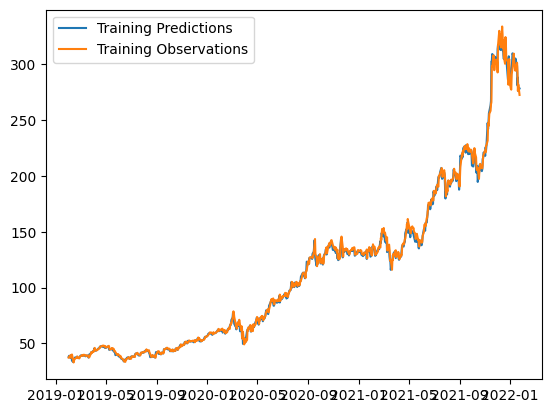

In [16]:
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(["Training Predictions", 'Training Observations'])

# Visualising performance of model

3/3 [==============================] - 0s 5ms/step


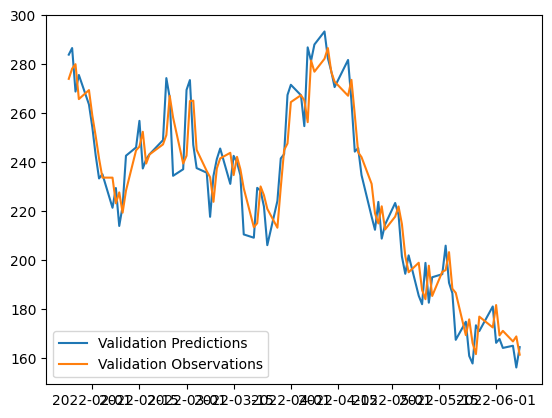

In [17]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(["Validation Predictions", 'Validation Observations'])

3/3 [==============================] - 0s 5ms/step


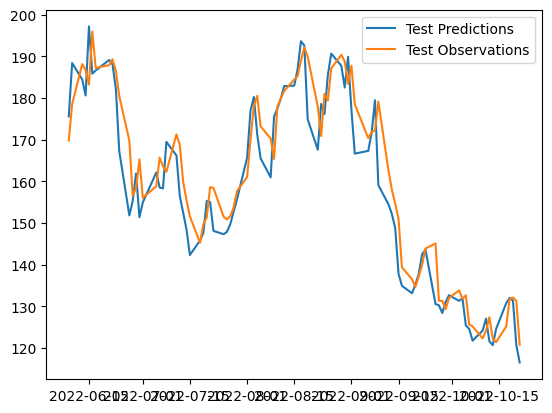

In [18]:
test_predictions = model.predict(X_test).flatten()
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(["Test Predictions", 'Test Observations'])

In [25]:
prediction = []
params = df.iloc[-1:,2:].to_numpy()
for i in range(10):
    close = model.predict([params])
    prediction.append(close[0][0])
    new_params = [close]
    new_params.extend(params[0][:-1])
    params[0] = new_params

1/1 [==============================] - 0s 23ms/step


/var/folders/z3/k29jsmxx1ds3zc21hy27hhk40000gn/T/ipykernel_9769/2162732357.py:8: DeprecationWarning:

setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.



1/1 [==============================] - 0s 17ms/step


In [26]:
print(prediction)

[120.687775, 116.49706, 115.37537, 115.43665, 118.9762, 112.05498, 118.558075, 119.28817, 120.36652, 122.0501]


## Assumption: Closing prices of the last 2 trading weeks (10 days) might give an indication to where the price at present day would be